In [1]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# load data

We will use something like (man=0.5, old=0.3) to predict the delta on each vertice. This will act as a morphtarget.

We use a json file with:
- vertices: the basemodel vertices
- morphtarget: the delta on vertices, 
    - ~~this is a list where each four is (i,dx,dy,dz), where i is the vertice~~
    - an array with an entry for each vertice
- and other things that we don't morph. We are just learning to generate new morphtargets

In [2]:
# load
from path import Path
data_path = Path('../data/20161107-224653_female1605_vae_data_combined')
# data_path = Path('../data/20161109-190329_None_vae_data')

from keras.utils.io_utils import HDF5Matrix

# split into validation data
X_train = HDF5Matrix(data_path.joinpath('X_train.hdf5'), 'data')
val_indice = int(len(X_train)*0.8)
test_indice = int(len(X_train)*0.9)

X_train = HDF5Matrix(data_path.joinpath('X_train.hdf5'), 'data', start=0, end=val_indice)
y_train = HDF5Matrix(data_path.joinpath('y_train.hdf5'), 'data', start=0, end=val_indice)
X_val = HDF5Matrix(data_path.joinpath('X_train.hdf5'), 'data', start=val_indice, end=test_indice)
y_val = HDF5Matrix(data_path.joinpath('y_train.hdf5'), 'data', start=val_indice, end=test_indice)
X_test = HDF5Matrix(data_path.joinpath('X_train.hdf5'), 'data', start=test_indice, end=None)
y_test = HDF5Matrix(data_path.joinpath('y_train.hdf5'), 'data', start=test_indice, end=None)

Using TensorFlow backend.


In [3]:
import json
metadata = json.load(open(data_path.joinpath('metadata.json')))

# restrict it to some macrovars to start with. In make human these override the others anyway.
whitelist= ['macrodetails/Gender',
 'macrodetails/Age',
 'macrodetails/African',
 'macrodetails/Asian',
 'macrodetails/Caucasian',
 'macrodetails-universal/Muscle',
 'macrodetails-universal/Weight',
 'macrodetails-height/Height',
 'macrodetails-proportions/BodyProportions']

modifier_names = sorted([(int(k),v) for k,v in metadata['target_dict'].items()])
modifier_names = [row[1] for row in modifier_names]
# modifier_names
# X_train.shape, y_train.shape, modifier_names

In [4]:
nb_targets = len(modifier_names)+1
nb_vertices = X_train.shape[1]
nb_dims = 3
hidden_dims = 107*3
batch_size = 256
nb_targets

270

# load into dataframes

In [5]:
y_df = pd.DataFrame(y_train.data[:],columns=modifier_names+['real'])
y_df

,head/head-age-less|more,head/head-angle-in|out,head/head-skinny|fat,head/head-oval,head/head-round,head/head-rectangular,head/head-square,head/head-triangular,head/head-invertedtriangular,head/head-diamond,...,measure/measure-waisttohip-decrease|increase,measure/measure-shoulder-decrease|increase,measure/measure-hips-decrease|increase,measure/measure-upperlegheight-decrease|increase,measure/measure-thighcirc-decrease|increase,measure/measure-lowerlegheight-decrease|increase,measure/measure-calf-decrease|increase,measure/measure-kneecirc-decrease|increase,measure/measure-ankle-decrease|increase,real
0,0.597920,0.538240,0.403265,0.520986,0.502408,0.566901,0.509204,0.580276,0.552586,0.562132,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
1,0.516053,0.529043,0.551922,0.568996,0.528239,0.573340,0.524186,0.521503,0.564406,0.522335,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
2,0.558509,0.636804,0.573528,0.544766,0.530271,0.518923,0.505807,0.579029,0.533283,0.553261,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
3,0.476686,0.396965,0.644556,0.569495,0.604044,0.534918,0.565432,0.515847,0.510349,0.552639,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
4,0.536622,0.448136,0.481211,0.544690,0.503457,0.525819,0.511197,0.537233,0.521525,0.566304,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
5,0.462143,0.435026,0.524284,0.524519,0.578049,0.533791,0.561842,0.581071,0.560129,0.556559,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
6,0.557750,0.371437,0.319376,0.533359,0.529933,0.507520,0.541834,0.536546,0.554619,0.500628,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
7,0.426730,0.466331,0.523746,0.526732,0.566355,0.528216,0.522854,0.519911,0.563082,0.560423,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
8,0.361923,0.542235,0.641263,0.540295,0.546716,0.536666,0.536369,0.521203,0.572680,0.504882,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
9,0.563866,0.335621,0.482658,0.517802,0.516958,0.569610,0.606937,0.547523,0.620222,0.526704,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0


In [6]:
x_df = pd.DataFrame(X_train.data[:].reshape((-1,3)), columns=['x','y','z'])
x_df

,x,y,z
0,-0.025758,0.903823,0.018281
1,0.033091,0.540104,0.259931
2,0.092691,0.510041,0.180619
3,-0.127753,0.677521,0.047245
4,-0.075185,0.879046,0.025577
5,-0.023143,0.818539,0.080601
6,0.008134,0.929834,-0.071734
7,-0.036582,0.911367,0.036989
8,-0.059767,0.840221,0.093407
9,0.028955,0.755403,0.161391


# how much for a representative sample?

Looks like it's just ~64 for x and ~256 for y

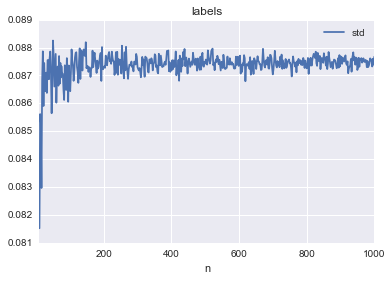

In [19]:
from collections import OrderedDict
# show y std
data=OrderedDict()
for n in np.round(np.linspace(10,1e3,500)).astype(int):
    std = y_df.sample(n,replace=True).std().mean()
    data[n]=std
    
df = pd.DataFrame(list(data.items()), columns=['n','std'])
df.plot('n')
plt.title('labels')

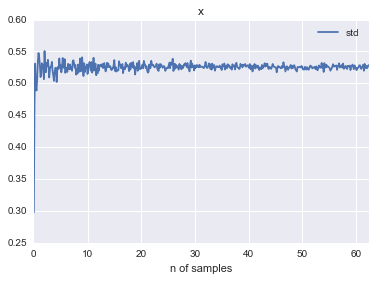

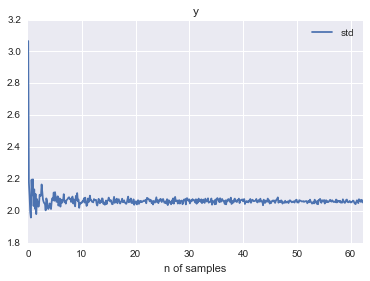

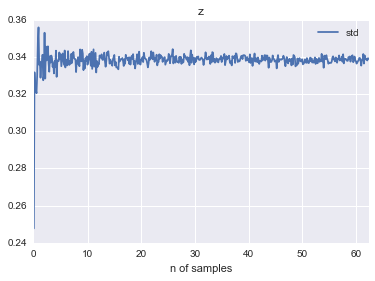

In [21]:
summaries = []
for n in np.round(np.linspace(10,1e5,500)).astype(int):
    summary = x_df.sample(n,replace=True).describe().to_dict()
    for col in x_df.columns:
        summary[col]['n']=n/nb_vertices
    summaries.append(summary)
    
for col in x_df.columns:
    df = pd.DataFrame([s[col] for s in summaries])
    df[['n','std']].plot('n')
    plt.title(col)
    plt.xlabel('n of samples')
    plt.show()

# Explore data

In [11]:
# check its normally dist from 0 to 1
for mod in y_df.columns:
    try:
        sns.distplot(y_df[mod], hist=False)
    except:
        pass

NameError: name 'y_df' is not defined

In [9]:
s = pd.Series(y.flatten())
s.describe()
s = None

In [10]:
X_df=pd.DataFrame(X.reshape((-1,3)),columns=['x','y','z'])

In [11]:
X_df.describe()

KeyError: MemoryError()

In [47]:
# sns.pairplot(X_df)

In [49]:
# sns.violinplot(data=X_df, palette="Set3", bw=.2, cut=1, linewidth=1)

In [12]:
X_df = None